# Preprocessing Twitter data for sentiment analysis

This notebook pre-processes the Twitter data for sentiment analysis.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer

from textblob import TextBlob
from wordcloud import WordCloud
from PIL import Image

tknzr = TweetTokenizer()
ps = nltk.PorterStemmer()

In [2]:
def remove_mentions_spaces(text, user_dict):
    '''
    Helper function for pre-processing tweets.
    Removes users mentioned in the tweet's
    provided user_dict, and also deletes new
    line and non-breaking space symbols. 
    '''
    users = re.findall(r"username\=\'(.+?)\'", user_dict)
    for user in users:
        text = text.replace(user.lower(), '').strip()
    
    text = text.replace('\n', ' ')
    text = text.replace('\xa0', ' ')
        
    return text

def stemming(text):
    '''
    Helper function for pre-processing tweets.
    Stems words and returns a string of stemmed words
    '''
    text = [ps.stem(text)][0]
    return text

In [5]:
def preprocess_data(df):
    '''
    Pre-processes the data as described below:
    
        - Limit to tweets in English
        - Transform to all lowercase
        - Remove URLs and HTML reference characters
        - Remove placeholders
        - Remove non-letter characters
        - Remove unnecessary columns
        - Change date to pd.datetime
        - Tokenize and stem
        
    '''
    processed_df = df.loc[df.lang == "en", :].copy()
    columns_to_keep = [
        'date', 'content', 'url', 'coordinates', 'place', 'id', 'username', 
        'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
        'conversationId', 'retweetedTweet', 'quotedTweet', 'outlinks', 
        'tcooutlinks', 'media', 'mentionedUsers'
    ]
    
    processed_df = processed_df[columns_to_keep]
    processed_df['date'] = pd.to_datetime(processed_df['date'], yearfirst=True, format="%Y-%m-%d")
    processed_df['simple_date'] = processed_df['date'].dt.date
    
    # Get hashtags
    processed_df['hashtags'] = processed_df['content'].apply(lambda x: re.findall(r'#(\w+)', x))
    
    # Remove mentions
    processed_df['mentions_removed'] = processed_df.apply(lambda x: remove_mentions_spaces(x.content, x.mentionedUsers), axis=1)
    
    # Clean up the text
    processed_df['text'] = processed_df['mentions_removed'].str.lower()
    processed_df.text = processed_df.text.apply(lambda x: re.sub(r"@(\w+)","", x)) # remove mentions that aren't in mentionedUsers
 
    # Clean up the text
    processed_df.text = processed_df.text.str.lower()
    processed_df.text = processed_df.text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    processed_df.text = processed_df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
    processed_df.text = processed_df.text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))
    processed_df.text = processed_df.text.apply(lambda x: re.sub(r"[^a-z0-9\s\(\-:\)\\\/\];=']", '', x))
    
    # Tokenize and stem
    processed_df['tokens'] = processed_df['text'].apply(tknzr.tokenize)
    processed_df['stemmed'] = processed_df['text'].apply(lambda x: stemming(x))
    
    return processed_df

## Pre-process data

In [6]:
# Load Twitter data
path, dirs, files = next(os.walk("data/"))
df_list = []
  
for file in files:
    if file.startswith('tweets'):
        print("Working on:", file)
        raw_df = pd.read_csv("data/" + file)
        clean_df = preprocess_data(raw_df)
        df_list.append(clean_df)

Working on: tweets_9.csv
Working on: tweets_8.csv
Working on: tweets_29.csv
Working on: tweets_15.csv
Working on: tweets_14.csv
Working on: tweets_28.csv
Working on: tweets_16.csv
Working on: tweets_17.csv
Working on: tweets_13.csv
Working on: tweets_12.csv
Working on: tweets_10.csv
Working on: tweets_38.csv
Working on: tweets_39.csv
Working on: tweets_11.csv
Working on: tweets_20.csv
Working on: tweets_34.csv
Working on: tweets_35.csv
Working on: tweets_21.csv
Working on: tweets_37.csv
Working on: tweets_23.csv
Working on: tweets_22.csv
Working on: tweets_36.csv
Working on: tweets_32.csv
Working on: tweets_26.csv
Working on: tweets_27.csv
Working on: tweets_33.csv
Working on: tweets_25.csv
Working on: tweets_31.csv
Working on: tweets_19.csv
Working on: tweets_18.csv
Working on: tweets_30.csv
Working on: tweets_24.csv
Working on: tweets_3.csv
Working on: tweets_2.csv
Working on: tweets_40.csv
Working on: tweets_1.csv
Working on: tweets_5.csv
Working on: tweets_4.csv
Working on: tweets_

In [7]:
# Append all the dataframes and save to data directory
main_df = pd.concat([df for df in df_list], ignore_index=True)
main_df.to_csv('data/preprocessed_data_sa.csv')

print("/nSaved preprocessed data for sentiment analysis.")
print("/nNumber of tweets:", main_df.shape[0])
print("Columns:", main_df.columns)

/nSaved preprocessed data for sentiment analysis.
/nNumber of tweets: 246014
Columns: Index(['date', 'content', 'url', 'coordinates', 'place', 'id', 'username',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'retweetedTweet', 'quotedTweet', 'outlinks',
       'tcooutlinks', 'media', 'mentionedUsers', 'simple_date', 'hashtags',
       'mentions_removed', 'text', 'tokens', 'stemmed'],
      dtype='object')


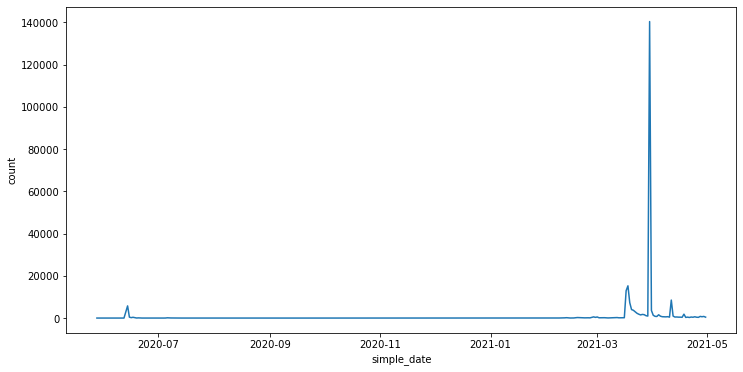

In [9]:
# Look at distribution of tweets over time
by_date = main_df.groupby(['simple_date'])['id'].count().reset_index(name='count')

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date, x="simple_date", y="count")

## Sentiment analysis
The rest of the notebook will analyze the sentiment of our Twitter data using NLTK's VADER lexicon and SentimentIntensityAnalyzer() classifier, which produces metrics representing a text's positivity, negativity, and neutrality; as well as TextBlob's sentiment method, which produces polarity and subjectivity scores.

In [12]:
def analyze_sentiment(df, col):
    '''
    Add sentiment metrics to a dataframe
    Use stemmed data for sentiment analysis
    '''
    df[['polarity', 'subjectivity']] = df[col].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

    for index, row in df[col].iteritems():
        score = SentimentIntensityAnalyzer().polarity_scores(row)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']

        if neg > pos:
            df.loc[index, 'sentiment'] = "negative"
        elif pos > neg:
            df.loc[index, 'sentiment'] = "positive"
        else:
            df.loc[index, 'sentiment'] = "neutral"

        df.loc[index, 'neg'] = neg
        df.loc[index, 'neu'] = neu
        df.loc[index, 'pos'] = pos
        df.loc[index, 'compound'] = comp

In [13]:
# Preview of tweets and their scores
analyze_sentiment(main_df, 'stemmed')
main_df[['content', 'stemmed', 'polarity', 'subjectivity', 'sentiment', 'compound']].sample(5)

,content,stemmed,polarity,subjectivity,sentiment,compound
28242,"You, I and we all have the right to be respect...",you i and we all have the right to be respecte...,0.285714,0.535714,positive,0.4767
183688,@Cindy05400163 I believe you are a nazi promot...,i believe you are a nazi promoting hate crime...,-0.800000,0.900000,negative,-0.2960
89734,@Cry_forthekpop STOP ASIAN HATE\nSTOP DISCRIMI...,stop asian hate stop discrimination stopaapih...,-0.400000,0.450000,negative,-0.7964
21471,@steveyeun proud of u steven yeun. we all need...,proud of u steven yeun we all need to stand t...,0.800000,1.000000,negative,-0.1343
85674,We stand against racial discrimination. \nWe c...,we stand against racial discrimination we con...,0.285714,0.535714,negative,-0.5574


In [14]:
main_df.groupby(['sentiment'])['id'].count()

sentiment
negative    151834
neutral      19346
positive     74834
Name: id, dtype: int64

## Visualize sentiment over time 

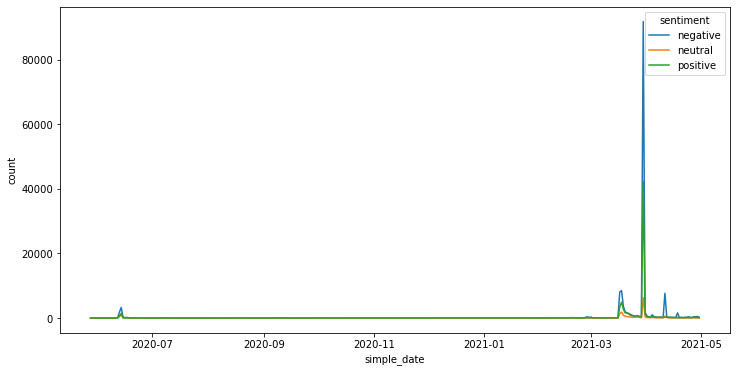

In [15]:
# Look at tweets over time
by_date_sentiment = main_df.groupby(['simple_date', 'sentiment'])['id'].count().reset_index(name='count')

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date_sentiment, x="simple_date", y="count", hue="sentiment")

## Find the most common words and n-grams across tweets, by sentiment

In [16]:
# Split into different dataframes
pos_df = main_df.loc[main_df['sentiment']=='positive']
neg_df = main_df.loc[main_df['sentiment']=='negative']
neut_df = main_df.loc[main_df['sentiment']=='neutral']

print("Number of positive tweets:", pos_df.shape[0])
print("Number of negative tweets:", neg_df.shape[0])
print("Number of neutral tweets", neut_df.shape[0])

Number of positive tweets: 74834
Number of negative tweets: 151834
Number of neutral tweets 19346


In [17]:
stopwords = nltk.corpus.stopwords.words("english")

# Remove hashtag text and stopwords for cleaner tokens 
stopwords.extend(['stopaapihate', 'atlantashooting', 'stopasianhatecrimes'])

def extract_words(df, col, remove_stopwords=True):
    '''
    Extracts words from columns and returns a list of token strings.
    We remove stopwords to clean up the tokens, but note that this 
    does not affect our sentiment analysis.
    '''
    words = ""
    for i, row in df.iterrows():
        if i == 0:
            words += row[col]
        else:
            words += (" " + row[col])
            
    tokenized: list[str] = nltk.word_tokenize(words)
    tokenized_clean = [w for w in tokenized if w.lower() not in stopwords]

    return tokenized_clean


def find_most_common(text, n):
    '''
    Given a list of strings, find the (n) most common words
    '''
    words = nltk.Text(text)
    fd = words.vocab()  # Equivalent to fd = nltk.FreqDist(words)
    
    return fd.tabulate(n)


def find_ngrams(text, n, k):
    '''
    Inputs:
    - n (int): 2, 3, or 4 
    - k (int): number of ngrams you want returned
    '''
    words = [w for w in nltk.Text(text) if w.isalpha()]
    if n == 2:
        finder = nltk.collocations.BigramCollocationFinder.from_words(words)
    elif n == 3:
        finder = nltk.collocations.TrigramCollocationFinder.from_words(words)
    elif n == 4:
        finder = nltk.collocations.QuadgramCollocationFinder.from_words(words)
    
    return finder.ngram_fd.most_common(k)

In [18]:
pos_words = extract_words(pos_df, 'stemmed')
neg_words = extract_words(neg_df, 'stemmed')
neutral_words = extract_words(neut_df, 'stemmed')

for df in [pos_words, neg_words, neutral_words]:
    find_most_common(df, 5)

stopasianhate     stopaapih     respected         right         stand 
        51288         29581         21960         21808         19350 
         stand  stopasianhate discrimination           stop       violence 
        101267          87765          81479          74865          58042 
    stopasianhate         stopaapih             stand          together stopasianhatecrim 
            11217              3235              3161              2317              1752 


In [19]:
find_ngrams(pos_words, 2, 5)

[(('stopasianhate', 'stopaapih'), 26655),
 (('right', 'respected'), 20109),
 (('stand', 'together'), 15627),
 (('together', 'stopasianhate'), 14272),
 (('respected', 'stand'), 14195)]

In [20]:
find_ngrams(pos_words, 3, 5)

[(('respected', 'stand', 'together'), 14060),
 (('stand', 'together', 'stopasianhate'), 13974),
 (('right', 'respected', 'stand'), 13957),
 (('stopaapih', 'right', 'respected'), 12080),
 (('stopasianhate', 'stopaapih', 'right'), 11833)]

In [21]:
find_ngrams(pos_words, 4, 5)

[(('right', 'respected', 'stand', 'together'), 13848),
 (('respected', 'stand', 'together', 'stopasianhate'), 13196),
 (('stopasianhate', 'stopaapih', 'right', 'respected'), 11808),
 (('stand', 'together', 'stopasianhate', 'stopaapih'), 11525),
 (('stopaapih', 'right', 'respected', 'stand'), 8439)]

In [22]:
find_ngrams(neg_words, 2, 5)

[(('condemn', 'violence'), 49365),
 (('racial', 'discrimination'), 49356),
 (('discrimination', 'condemn'), 49113),
 (('stand', 'racial'), 49033),
 (('right', 'respected'), 47852)]

In [23]:
find_ngrams(neutral_words, 2, 5)

[(('stopasianhate', 'stopaapih'), 2545),
 (('stand', 'together'), 1980),
 (('together', 'stopasianhate'), 1623),
 (('stopasianhate', 'stopasianhatecrim'), 1113),
 (('stopasianhate', 'stand'), 892)]

In [24]:
find_ngrams(neutral_words, 3, 5)

[(('stand', 'together', 'stopasianhate'), 1487),
 (('together', 'stopasianhate', 'stopaapih'), 932),
 (('stopasianhate', 'stopaapih', 'stand'), 718),
 (('sonny', 'stopasianhate', 'stopasianhatecrim'), 592),
 (('stopaapih', 'stand', 'together'), 583)]

In [25]:
find_ngrams(neg_words, 3, 5)

[(('discrimination', 'condemn', 'violence'), 49101),
 (('stand', 'racial', 'discrimination'), 48986),
 (('racial', 'discrimination', 'condemn'), 48971),
 (('right', 'respected', 'stand'), 47373),
 (('condemn', 'violence', 'right'), 47280)]

In [26]:
# Look at unique words in the positive and negative sets
positive_fd = nltk.FreqDist(pos_words)
negative_fd = nltk.FreqDist(neg_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_20_positive = {word for word, count in positive_fd.most_common(20)}
top_20_negative = {word for word, count in negative_fd.most_common(20)}

In [27]:
top_20_positive

{'anitha',
 'asifa',
 'charitystream',
 'covid-53',
 'fip',
 'gobacksadistmodi',
 'gs441524',
 'hateshut',
 'html',
 'limengyanyanlimengshut',
 'livelaughlove',
 'neurological',
 'pleasesharebeaware',
 'pollachiwomenrapist',
 'scry',
 'silenceisacceptance',
 'snowlin',
 'tnassemblyelections2021',
 'tnelection2021',
 'wemustdobetter'}

In [28]:
top_20_negative

{'appallingly',
 'colluded',
 'covid-19bannon',
 'felony',
 'gz',
 'irkla',
 'johncornyn',
 'limengyanyanlimengyou',
 'pei',
 'peng',
 'prohibits',
 'qualifications',
 'racismisnotcom',
 'racismisnotcomedyracism',
 'recial',
 'sinners',
 'thief',
 'weloveyoubt',
 'you039',
 'yumma'}

Wordcloud saved as  wc_alltweets.png


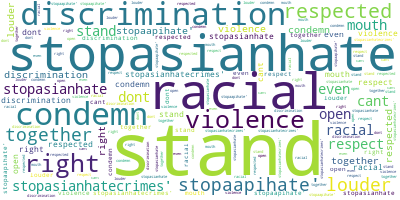

In [29]:
def create_wordcloud(text, save_as):
    '''
    Build a wordcloud using text to illustrate the 
    prominence of specific words
    '''
    wc = WordCloud(background_color="white", max_words=3000, stopwords=stopwords, repeat=True)
    wc.generate(str(text))
    wc.to_file(save_as)
    print("Wordcloud saved as ", save_as)
    path = save_as
    display(Image.open(path))
    
create_wordcloud(main_df["text"].values, "wc_alltweets.png")

Wordcloud saved as  wc_postweets.png


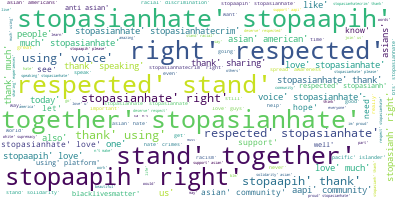

In [30]:
create_wordcloud(pos_words, "wc_postweets.png")

Wordcloud saved as  wc_negtweets.png


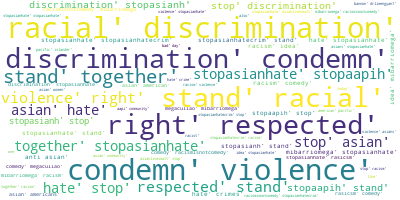

In [31]:
create_wordcloud(neg_words, "wc_negtweets.png")

Wordcloud saved as  wc_neutweets.png


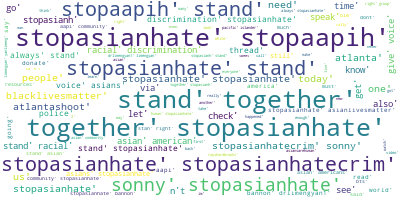

In [32]:
create_wordcloud(neutral_words, "wc_neutweets.png")

## Analyze sentiment by topic
Note that for this analysis, the input is slightly different. In order to create topics, we used stopwords to filter out noise, so this might affect the sentiment analysis.

In [33]:
# Read in CSV
topics_df = pd.read_csv('data/dgmm_results.csv')

# Drop the first column (i.e., Unnamed: 0)
topics_df = topics_df[['Text', 'Topic', 'Lemmatized']]

topics_df.head(5)

,Text,Topic,Lemmatized
0,we've raised thru tix sticker pack sales so f...,Topic 11,"[""we've_raised"", 'tix', 'sticker_pack', 'sale'..."
1,thank you and all of the family for your ongoi...,Topic 15,"['thank', 'family', 'ongoing', 'support', 'tea..."
2,do we have a picture of the racist perp maybe ...,Topic 13,"['picture', 'racist', 'perp', 'maybe', 'commun..."
3,southern fried asian panel on,Topic 15,"['southern', 'fried', 'asian', 'panel']"
4,bitch how do you mispronounce boba,Topic 13,"['bitch', 'mispronounce', 'boba']"


In [34]:
print("Number of tweets in the topic-labeled data", topics_df.shape)

Number of tweets in the topic-labeled data (245987, 3)


In [35]:
analyze_sentiment(topics_df, 'Text')
topics_df.head(5)

,Text,Topic,Lemmatized,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,we've raised thru tix sticker pack sales so f...,Topic 11,"[""we've_raised"", 'tix', 'sticker_pack', 'sale'...",0.100000,1.000000,neutral,0.000,1.000,0.000,0.0000
1,thank you and all of the family for your ongoi...,Topic 15,"['thank', 'family', 'ongoing', 'support', 'tea...",0.000000,0.000000,negative,0.241,0.609,0.151,-0.6249
2,do we have a picture of the racist perp maybe ...,Topic 13,"['picture', 'racist', 'perp', 'maybe', 'commun...",-0.155556,0.288889,negative,0.169,0.717,0.114,-0.3182
3,southern fried asian panel on,Topic 15,"['southern', 'fried', 'asian', 'panel']",0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
4,bitch how do you mispronounce boba,Topic 13,"['bitch', 'mispronounce', 'boba']",0.000000,0.000000,negative,0.432,0.568,0.000,-0.5859


In [36]:
# Save topic data
topics_df.to_csv('data/topics_with_sentiment.csv')

In [53]:
# Add a column to help sort the topics
def extract_number(text):
    if text == "Unknown":
        return None
    else: # i.e. "Topic X"
        return int(text[6:])

topics_df['topic_number'] = topics_df['Topic'].apply(lambda x: extract_number(x))
topics_df.head()

,Text,Topic,Lemmatized,polarity,subjectivity,sentiment,neg,neu,pos,compound,topic_number
0,we've raised thru tix sticker pack sales so f...,Topic 11,"[""we've_raised"", 'tix', 'sticker_pack', 'sale'...",0.100000,1.000000,neutral,0.000,1.000,0.000,0.0000,11.0
1,thank you and all of the family for your ongoi...,Topic 15,"['thank', 'family', 'ongoing', 'support', 'tea...",0.000000,0.000000,negative,0.241,0.609,0.151,-0.6249,15.0
2,do we have a picture of the racist perp maybe ...,Topic 13,"['picture', 'racist', 'perp', 'maybe', 'commun...",-0.155556,0.288889,negative,0.169,0.717,0.114,-0.3182,13.0
3,southern fried asian panel on,Topic 15,"['southern', 'fried', 'asian', 'panel']",0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000,15.0
4,bitch how do you mispronounce boba,Topic 13,"['bitch', 'mispronounce', 'boba']",0.000000,0.000000,negative,0.432,0.568,0.000,-0.5859,13.0


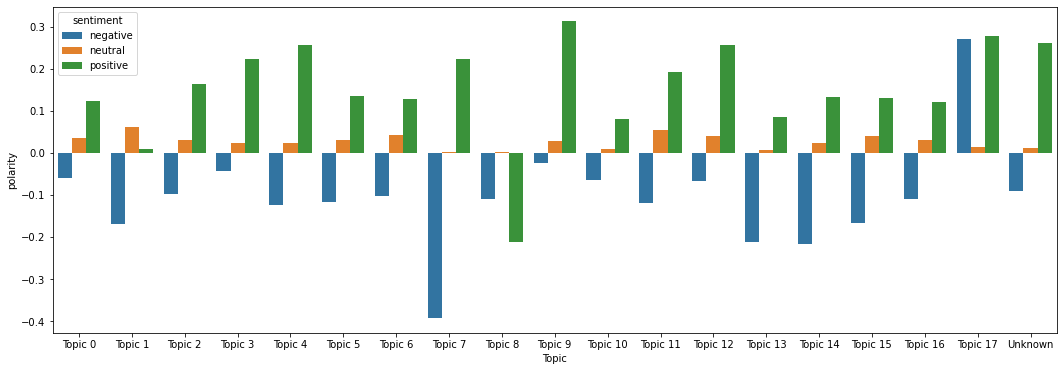

In [62]:
# Analyze by sentiment by topic
by_topic_sentiment = topics_df.groupby(['Topic', 'sentiment']).agg({'polarity': 'mean', 'subjectivity': 'mean', 'sentiment': 'count', 'compound': 'mean'})

fig, ax = plt.subplots(figsize = (18,6))    
fig = sns.barplot(x="Topic", y="polarity", hue="sentiment", ci=None, data=topics_df.sort_values('topic_number'))

In [56]:
by_topic_sentiment.head()

polarity  subjectivity  sentiment  compound
Topic   sentiment                                             
Topic 0 negative  -0.058744      0.249729        144 -0.647772
        neutral    0.035237      0.106970         54  0.000000
        positive   0.123974      0.495794        212  0.552357
Topic 1 negative  -0.168608      0.296083        444 -0.847200
        neutral    0.062610      0.111314         49  0.000000

In [58]:
by_topic = topics_df.groupby(['Topic']).agg({'polarity': 'mean', 'subjectivity': 'mean', 'compound': 'mean'})
by_topic

,polarity,subjectivity,compound
Topic,,,
Topic 0,0.048113,0.358160,0.058099
Topic 1,-0.128306,0.282862,-0.637577
Topic 10,-0.026091,0.342875,-0.350187
Topic 11,0.116859,0.338337,0.280907
Topic 12,0.200614,0.384721,0.410049
Topic 13,-0.140959,0.430224,-0.431712
Topic 14,-0.080174,0.425884,-0.194226
Topic 15,-0.033565,0.360283,-0.159707
Topic 16,-0.023701,0.376546,-0.237945


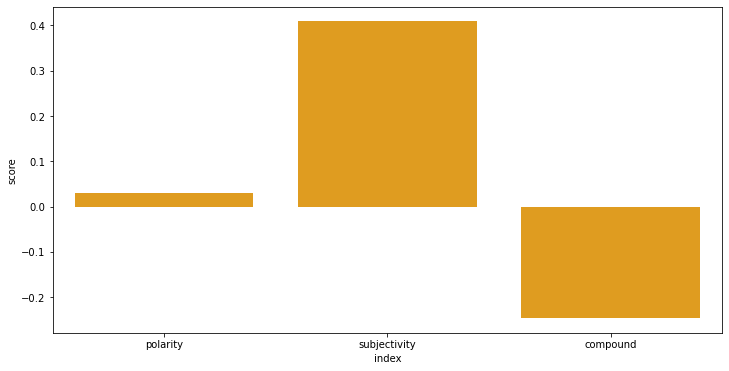

In [59]:
overall_sentiment = topics_df.agg({'polarity': 'mean', 'subjectivity': 'mean', 'compound': 'mean'}).reset_index(name="score")
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x="index", y="score", ci=None, color="orange", data=overall_sentiment)

In [60]:
overall_sentiment

,index,score
0,polarity,0.029102
1,subjectivity,0.408880
2,compound,-0.246305


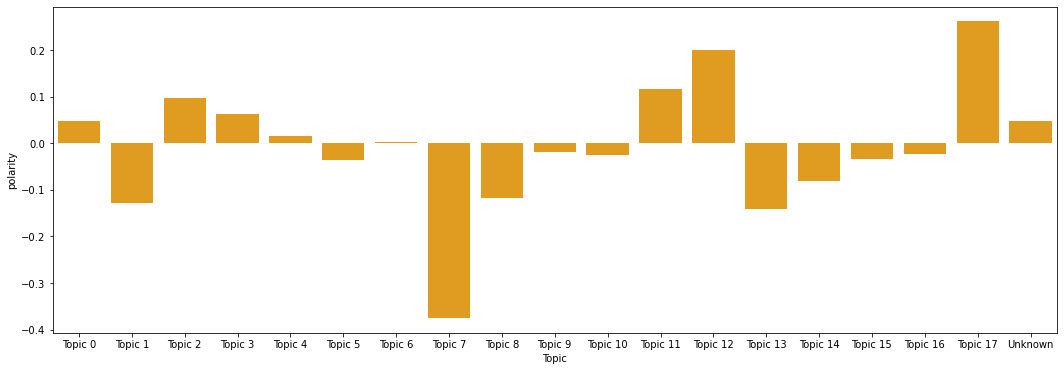

In [64]:
by_topic_polarity = topics_df.groupby('Topic').agg({'polarity': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize = (18,6))    
fig = sns.barplot(x="Topic", y="polarity", color="orange", ci=None, data=topics_df.sort_values('topic_number'))

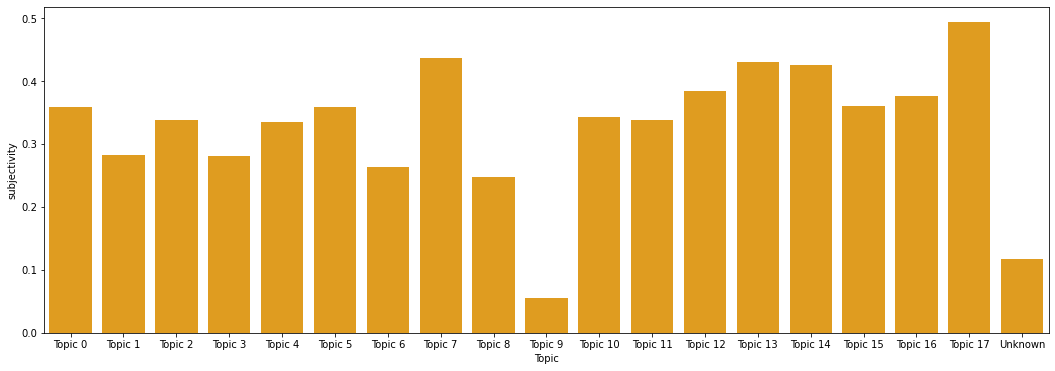

In [65]:
by_topic_subjectivity = topics_df.groupby('Topic').agg({'subjectivity': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize = (18,6))    
fig = sns.barplot(x="Topic", y="subjectivity", color="orange", ci=None, data=topics_df.sort_values('topic_number'))

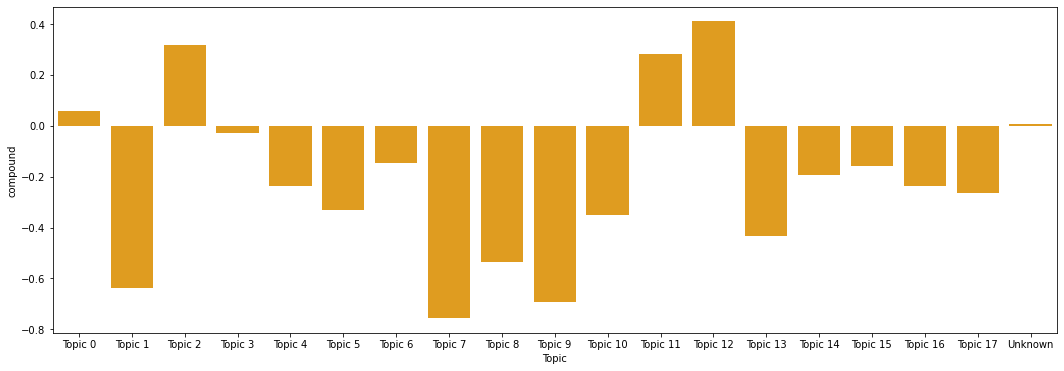

In [66]:
by_topic_compound = topics_df.groupby('Topic').agg({'compound': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize = (18,6))    
fig = sns.barplot(x="Topic", y="compound", color="orange", ci=None, data=topics_df.sort_values('topic_number'))

# Examine over time

Text(0.5, 1.0, 'Number of tweets by sentiment over time starting 1/1/2021, before the BTS statements')

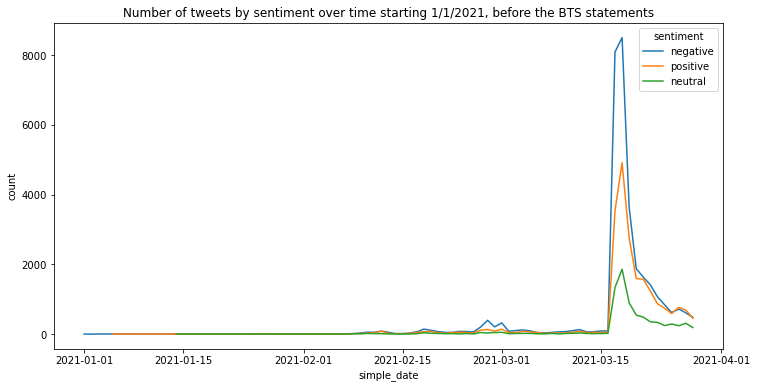

In [112]:
# Pre-BTS 2021
bts_date = pd.to_datetime("2021-03-29", format='%Y-%m-%d')
ny_2021 = pd.to_datetime("2021-01-01", format='%Y-%m-%d')
atlanta_shooting = pd.to_datetime("2021-03-16", format='%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date_sentiment.loc[(by_date_sentiment['simple_date'] >= ny_2021) & (by_date_sentiment['simple_date'] < bts_date)], x="simple_date", y="count", hue="sentiment")
ax.set_title("Number of tweets by sentiment over time starting 1/1/2021, before the BTS statements")

Text(0.5, 1.0, 'Number of tweets by sentiment over time starting 1/1/2021, before the Atlanta Shooting')

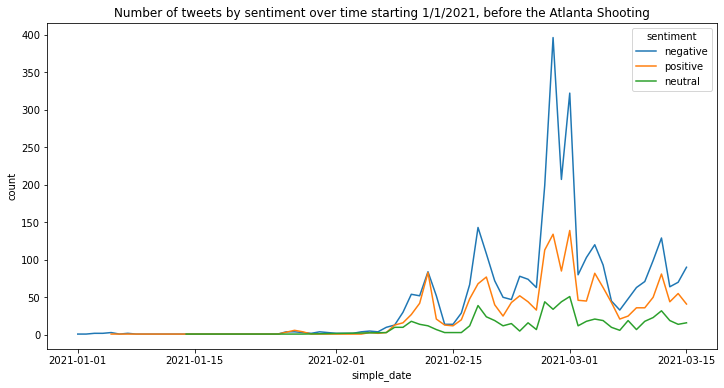

In [111]:
# Pre-Atlanta shooting
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date_sentiment.loc[(by_date_sentiment['simple_date'] >= ny_2021) & (by_date_sentiment['simple_date'] < atlanta_shooting)], x="simple_date", y="count", hue="sentiment")
ax.set_title("Number of tweets by sentiment over time starting 1/1/2021, before the Atlanta Shooting")

Text(0.5, 1.0, 'Number of tweets by sentiment over time in 2020')

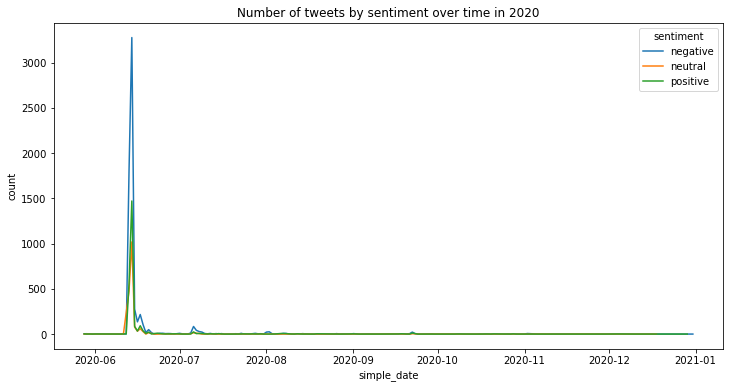

In [113]:
# Look at tweets in 2020
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date_sentiment.loc[by_date_sentiment['simple_date'] < ny_2021], x="simple_date", y="count", hue="sentiment")
ax.set_title("Number of tweets by sentiment over time in 2020")

# Note: Rayshard Brooks was killed by police in Atlanta on June 12

In [68]:
df_atlanta_shooting = main_df.loc[(main_df['simple_date'] > atlanta_shooting) & (main_df['simple_date'] < bts_date)]
df_atlanta_shooting[['content', 'polarity', 'subjectivity', 'neg', 'compound']].sort_values('compound')

,content,polarity,subjectivity,neg,compound
136794,"Not only CAN WE SEE it, but WE CAN FEEL THE HA...",-0.700000,0.912500,0.696,-0.9969
104319,STOP ASIAN HATE.\nSTOP ASIAN HATE.\nSTOP ASIAN...,-0.400000,0.450000,0.845,-0.9966
95519,WHY CAN’T WE CALL IT WHAT IT IS.\n\nAsk any As...,-0.594444,0.727778,0.597,-0.9944
118020,Stop Asian Hate. Stop Asian Hate. Stop Asian H...,-0.347368,0.382456,0.674,-0.9938
94013,@ACLU @nguyen_amanda STOP HATE. STOP HATE.\nST...,-0.800000,0.900000,0.904,-0.9924
...,...,...,...,...,...
170570,"Being Asian is not a crime, but racism is. I f...",0.353704,0.703704,0.102,0.9849
93815,Thank you DJpanic.I have great respect for you...,0.575000,0.612500,0.000,0.9868
97130,"Please treat each other with love and respect,...",0.175000,0.385000,0.000,0.9868
137936,Love us like you love our food.\n\nLove us lik...,0.450000,0.550000,0.000,0.9944


In [69]:
main_df.sort_values('compound').iloc[0]['content']

'Not only CAN WE SEE it, but WE CAN FEEL THE HATE. Stop the BS coverage. @CNN - it was a hate crime @MSNBC - it was a hate crime @latimes - it was a hate \n@washingtonpost  - it was a hate crime @nytimes - it was a hate crime @foxnews 🖕🏽- it was a hate crime #StopAsianHateCrimes https://t.co/P4EURViLL4'

In [70]:
main_df.sort_values('compound', ascending=False).iloc[0]['content']

'LOVE THEM LIKE YOU LOVE THEIR FOOD.\nLOVE THEM LIKE YOU LOVE THEIR SERIES.\nLOVE THEM LIKE YOU LOVE THEIR SONGS.\nLOVE THEM LIKE YOU LOVE THEIR ANIMATIONS.\nLOVE THEM LIKE YOU LOVE THEIR WRITINGS.\n#StopAsianHate \n#StopAsianHateCrimes \n#StopAAPIHate'

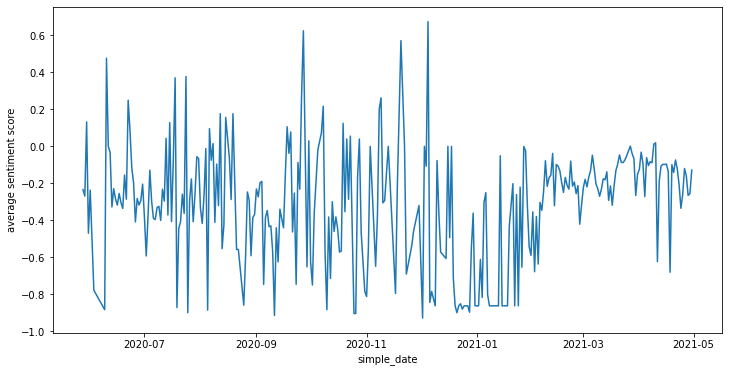

In [94]:
by_date_compound = main_df.groupby(['simple_date'])['compound'].mean().reset_index(name='average sentiment score')

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date_compound, x="simple_date", y="average sentiment score", ci=None)

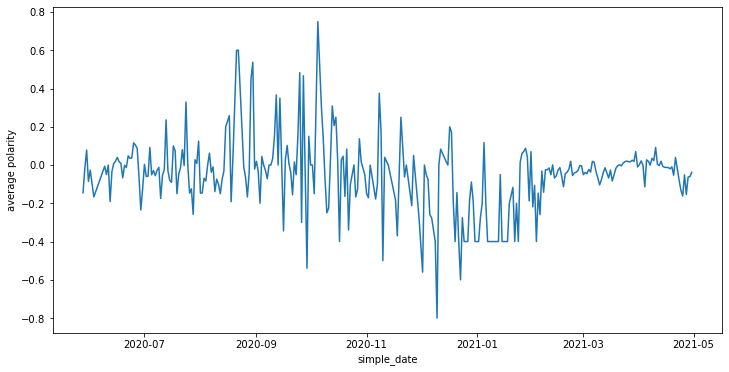

In [74]:
by_date_polarity = main_df.groupby(['simple_date'])['polarity'].mean().reset_index(name ='average polarity')

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date_polarity, x="simple_date", y="average polarity")

Text(0.5, 1.0, 'Polarity of positive tweets over time')

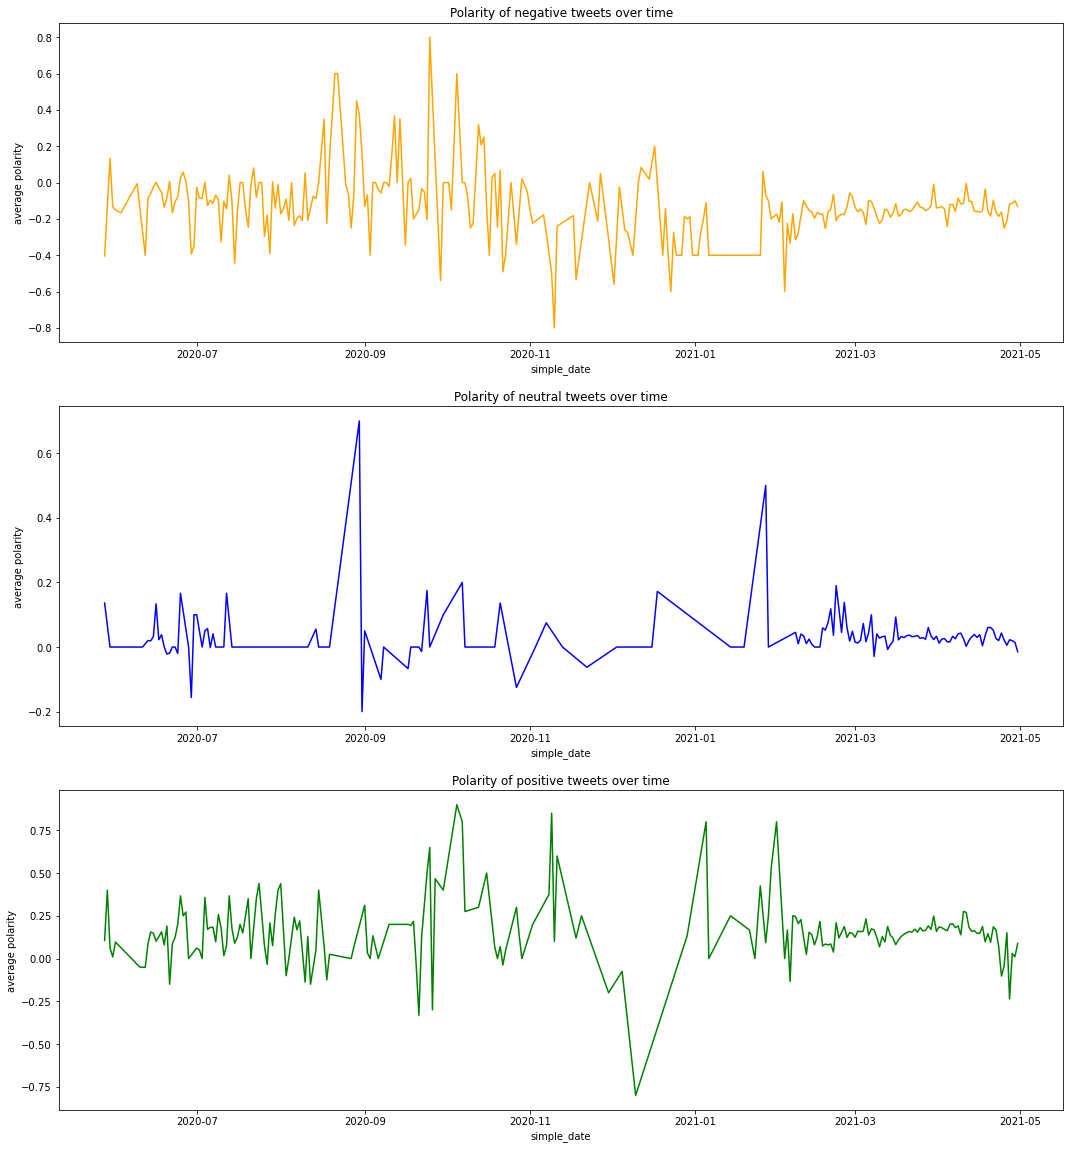

In [101]:
by_date_polarity = main_df.groupby(['simple_date', 'sentiment'])['polarity'].mean().reset_index(name ='average polarity')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (18,20))

sns.lineplot(ax=ax1, data=by_date_polarity[by_date_polarity["sentiment"]=="negative"], x="simple_date", y="average polarity", color="orange")
ax1.set_title("Polarity of negative tweets over time")

sns.lineplot(ax=ax2, data=by_date_polarity[by_date_polarity["sentiment"]=="neutral"], x="simple_date", y="average polarity", color="blue")
ax2.set_title("Polarity of neutral tweets over time")

sns.lineplot(ax=ax3, data=by_date_polarity[by_date_polarity["sentiment"]=="positive"], x="simple_date", y="average polarity", color="green")
ax3.set_title("Polarity of positive tweets over time")

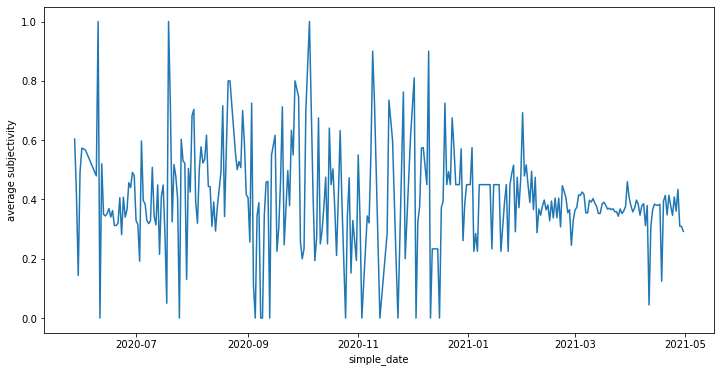

In [76]:
by_date_subjectivity = main_df.groupby(['simple_date'])['subjectivity'].mean().reset_index(name ='average subjectivity')

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(data=by_date_subjectivity, x="simple_date", y="average subjectivity")

Text(0.5, 1.0, 'Subjectivity of positive tweets over time')

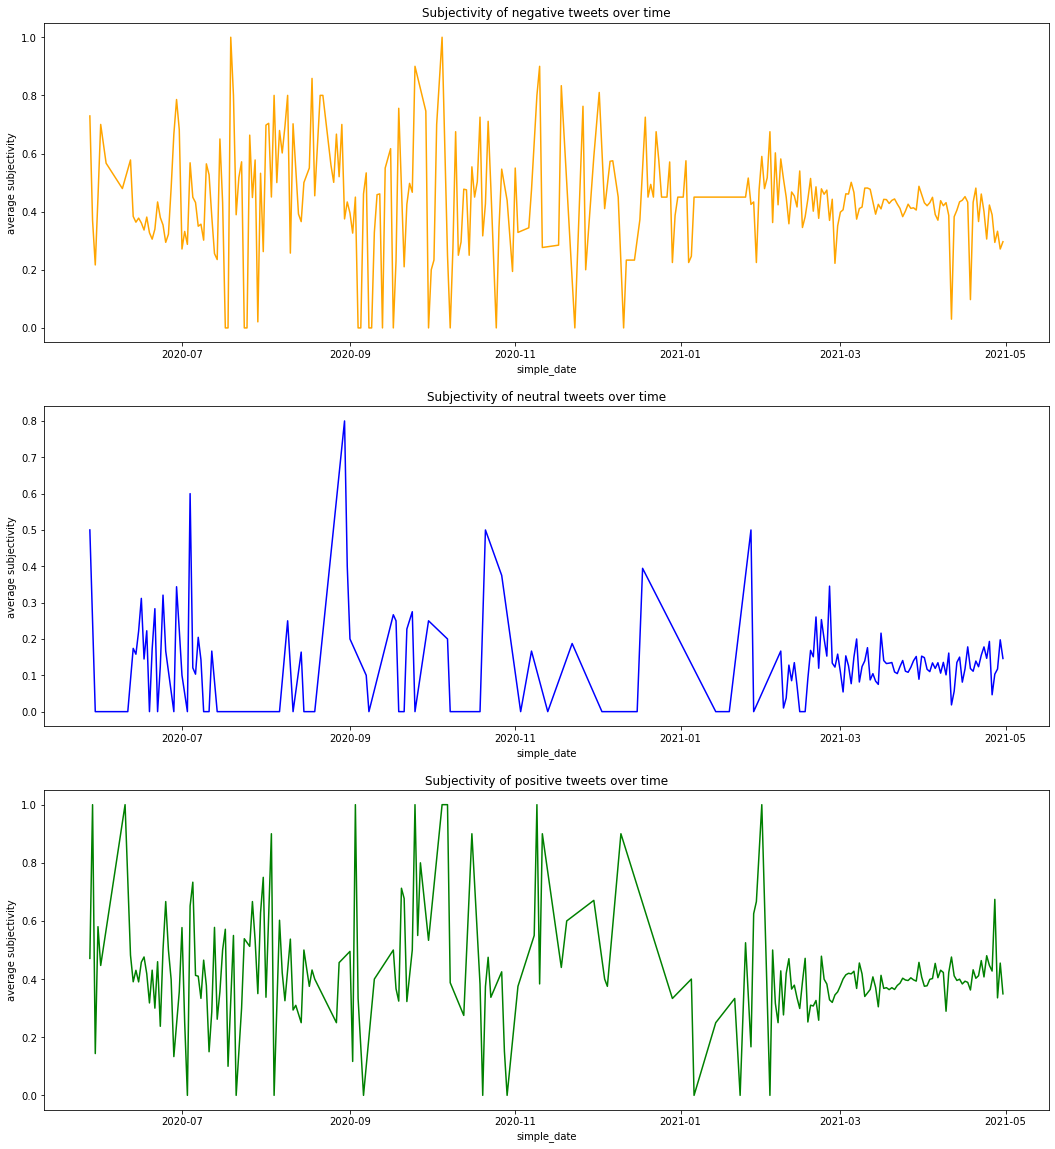

In [102]:
by_date_subjectivity = main_df.groupby(['simple_date', 'sentiment'])['subjectivity'].mean().reset_index(name ='average subjectivity')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (18,20))

sns.lineplot(ax=ax1, data=by_date_subjectivity[by_date_subjectivity["sentiment"]=="negative"], x="simple_date", y="average subjectivity", color="orange")
ax1.set_title("Subjectivity of negative tweets over time")

sns.lineplot(ax=ax2, data=by_date_subjectivity[by_date_subjectivity["sentiment"]=="neutral"], x="simple_date", y="average subjectivity", color="blue")
ax2.set_title("Subjectivity of neutral tweets over time")

sns.lineplot(ax=ax3, data=by_date_subjectivity[by_date_subjectivity["sentiment"]=="positive"], x="simple_date", y="average subjectivity", color="green")
ax3.set_title("Subjectivity of positive tweets over time")

In [83]:
main_df.loc[main_df['content'].str.lower().str.contains('stopasianhatecrimes')].sort_values('simple_date')[['simple_date','content','hashtags']].head(10)

,simple_date,content,hashtags
72903,2020-11-17,Why are Asian hate crimes and Asian protests n...,"[asianpride, stopasianhatecrimes]"
72763,2021-02-05,#vicharatanapakdee #justiceforVichaRatanapakde...,"[vicharatanapakdee, justiceforVichaRatanapakde..."
72752,2021-02-06,This elderly Filipino mans face was slashed in...,"[HATEISAVIRUS, stopasianhatecrimes]"
72751,2021-02-06,This 91 year old man was pushed in broad light...,[stopasianhatecrimes]
72745,2021-02-07,@JoyceTakako @danieldaekim @danielwuyanzu @lis...,[STOPAsianHateCrimes]
72744,2021-02-07,@e01_9 @danieldaekim @danielwuyanzu @lisaling ...,[StopAsianHateCrimes]
72735,2021-02-07,@mjmichellekim @JoyceTakako We using #StopAsia...,[StopAsianHateCrimes]
72710,2021-02-08,Asian Americans Are Calling on Allies in Respo...,[StopAsianHateCrimes]
72706,2021-02-08,What say you @OCANational ?\n\nWhat can we do ...,[StopAsianHateCrimes]
72705,2021-02-08,@mingoose2 @JoyceTakako @XxYoungxLeeXx @akong3...,[StopAsianHateCrimes]


In [85]:
main_df.loc[main_df['content'].str.lower().str.contains('stopasianhate')].sort_values('simple_date')[['simple_date','content','hashtags']].head(10)

,simple_date,content,hashtags
72903,2020-11-17,Why are Asian hate crimes and Asian protests n...,"[asianpride, stopasianhatecrimes]"
72763,2021-02-05,#vicharatanapakdee #justiceforVichaRatanapakde...,"[vicharatanapakdee, justiceforVichaRatanapakde..."
72752,2021-02-06,This elderly Filipino mans face was slashed in...,"[HATEISAVIRUS, stopasianhatecrimes]"
72751,2021-02-06,This 91 year old man was pushed in broad light...,[stopasianhatecrimes]
72745,2021-02-07,@JoyceTakako @danieldaekim @danielwuyanzu @lis...,[STOPAsianHateCrimes]
72744,2021-02-07,@e01_9 @danieldaekim @danielwuyanzu @lisaling ...,[StopAsianHateCrimes]
72735,2021-02-07,@mjmichellekim @JoyceTakako We using #StopAsia...,[StopAsianHateCrimes]
72707,2021-02-08,#StopAsianHateCrimes\n\n@weijia Thank you. ✊💛 ...,[StopAsianHateCrimes]
72706,2021-02-08,What say you @OCANational ?\n\nWhat can we do ...,[StopAsianHateCrimes]
72705,2021-02-08,@mingoose2 @JoyceTakako @XxYoungxLeeXx @akong3...,[StopAsianHateCrimes]


In [87]:
main_df.loc[main_df['content'].str.lower().str.contains('stopaapihate')].sort_values('simple_date')[['simple_date','content','hashtags']].head()

,simple_date,content,hashtags
214879,2020-05-28,People continue to wrongly blame Asians for #C...,"[COVID19, StopAAPIHate]"
214872,2020-05-28,"If you want to do more, also check out @ColorO...","[SAPFF, APAHM, AAPIHM, AsiansForBlackLives, St..."
214873,2020-05-28,"CW: Anti-Asian Hate, Racism, Xenophobia, Infla...","[UMAgainstAAPIHate, StopAAPIHate, HateIsAVirus..."
214874,2020-05-28,"1,800 incidents of #AAPI #COVID harassment rep...","[AAPI, COVID, StopAAPIHate]"
214878,2020-05-28,People continue to wrongly blame Asians for #C...,"[COVID19, StopAAPIHate]"


In [122]:
aapi_df = main_df.loc[(main_df['content'].str.lower().str.contains('aapi')) | (main_df['content'].str.lower().str.contains('stopasianhate')) | (main_df['content'].str.lower().str.contains('stopasianhatecrimes')) | (main_df['content'].str.lower().str.contains('hateisavirus'))].sort_values('simple_date')

In [123]:
aapi_df.shape

(235266, 31)

In [125]:
aapi_df.head(5)

,date,content,url,coordinates,place,id,username,replyCount,retweetCount,likeCount,...,text,tokens,stemmed,polarity,subjectivity,sentiment,neg,neu,pos,compound
214873,2020-05-28 19:02:56+00:00,"CW: Anti-Asian Hate, Racism, Xenophobia, Infla...",https://twitter.com/umaaapih/status/1266082548...,NaN,NaN,1266082548611833857,umaaapih,0,1,1,...,cw: anti-asian hate racism xenophobia inflamma...,"[cw, :, anti-asian, hate, racism, xenophobia, ...",cw: anti-asian hate racism xenophobia inflamma...,-0.266667,0.900000,negative,0.310,0.620,0.070,-0.8722
214879,2020-05-28 16:44:21+00:00,People continue to wrongly blame Asians for #C...,https://twitter.com/AsmPhilTing/status/1266047...,NaN,NaN,1266047671136972800,AsmPhilTing,1,0,1,...,people continue to wrongly blame asians for co...,"[people, continue, to, wrongly, blame, asians,...",people continue to wrongly blame asians for co...,-0.433333,0.766667,negative,0.190,0.782,0.027,-0.8271
214878,2020-05-28 16:45:34+00:00,People continue to wrongly blame Asians for #C...,https://twitter.com/PhilTing/status/1266047977...,NaN,NaN,1266047977493131270,PhilTing,2,0,5,...,people continue to wrongly blame asians for co...,"[people, continue, to, wrongly, blame, asians,...",people continue to wrongly blame asians for co...,-0.433333,0.766667,negative,0.190,0.782,0.027,-0.8271
214877,2020-05-28 17:26:43+00:00,Watch @KulkarniManju in conversation with NowT...,https://twitter.com/A3PCON/status/126605833141...,NaN,NaN,1266058331417763840,A3PCON,0,1,2,...,watch in conversation with nowthis amanda cho...,"[watch, in, conversation, with, nowthis, amand...",watch in conversation with nowthis amanda cho...,0.136364,0.500000,neutral,0.000,1.000,0.000,0.0000
214876,2020-05-28 18:01:10+00:00,2) Asian-American &amp; Pacific Islander peopl...,https://twitter.com/1defendyourself/status/126...,NaN,NaN,1266067002101100544,1defendyourself,0,0,2,...,2) asian-american pacific islander people: jo...,"[2, ), asian-american, pacific, islander, peop...",2) asian-american pacific islander people: jo...,0.009091,0.580303,positive,0.195,0.594,0.211,0.1779


Text(0.5, 1.0, 'Number of positive tweets by AAPI/Asian-focused sentiment over time in 2020')

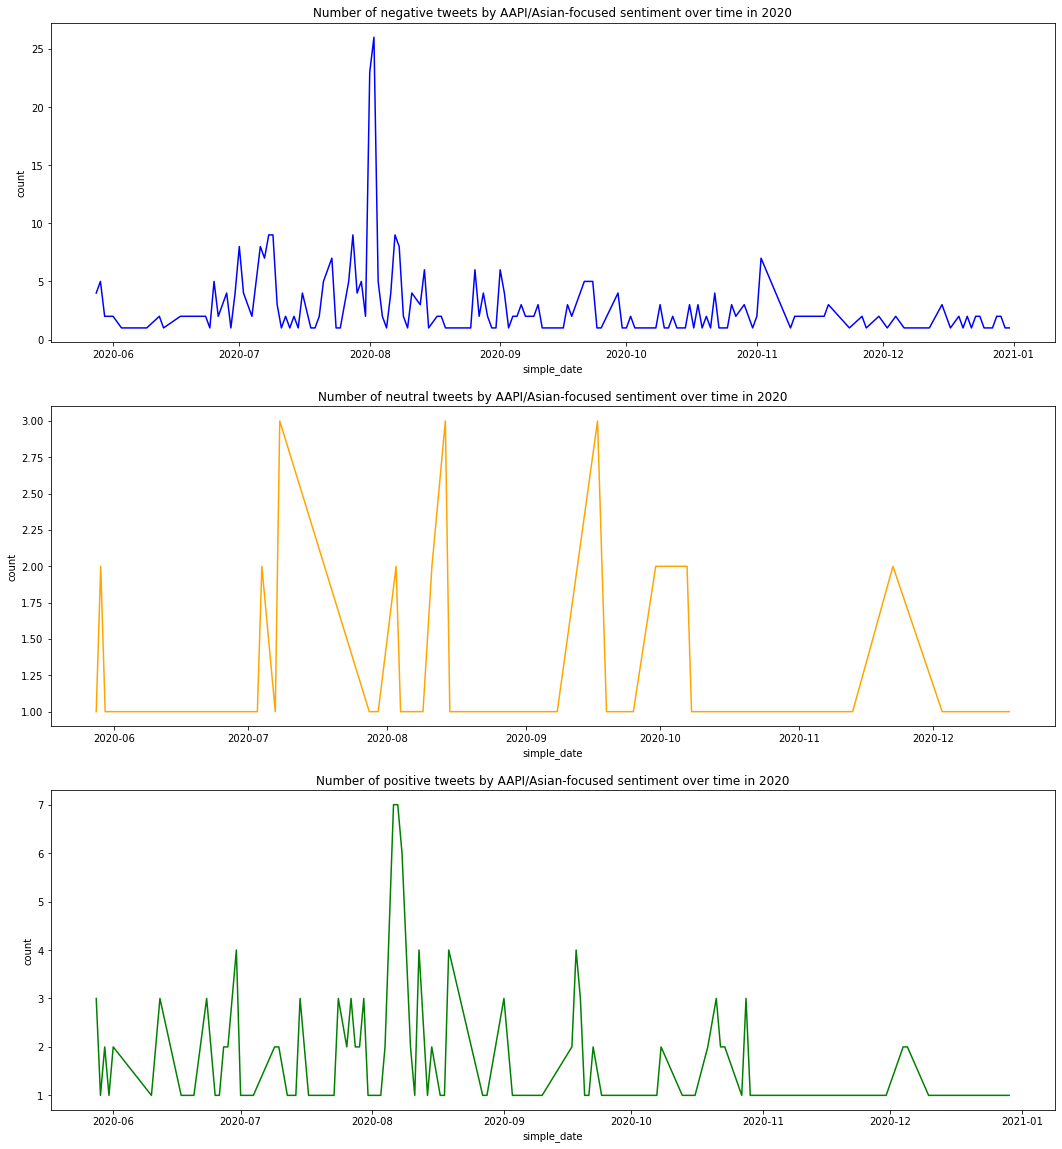

In [130]:
# Look at AAPI-focused tweets in 2020
aapi_by_date_sentiment = aapi_df.groupby(['simple_date', 'sentiment'])['sentiment'].count().reset_index(name ='count')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (18,20))    

sns.lineplot(ax=ax1, data=aapi_by_date_sentiment.loc[(aapi_by_date_sentiment['simple_date'] < ny_2021) & (aapi_by_date_sentiment['sentiment'] == "negative")], x="simple_date", y="count", color="blue")
ax1.set_title("Number of negative tweets by AAPI/Asian-focused sentiment over time in 2020")

sns.lineplot(ax=ax2, data=aapi_by_date_sentiment.loc[(aapi_by_date_sentiment['simple_date'] < ny_2021) & (aapi_by_date_sentiment['sentiment'] == "neutral")], x="simple_date", y="count", color="orange")
ax2.set_title("Number of neutral tweets by AAPI/Asian-focused sentiment over time in 2020")

sns.lineplot(ax=ax3, data=aapi_by_date_sentiment.loc[(aapi_by_date_sentiment['simple_date'] < ny_2021) & (aapi_by_date_sentiment['sentiment'] == "positive")], x="simple_date", y="count", color="green")
ax3.set_title("Number of positive tweets by AAPI/Asian-focused sentiment over time in 2020")

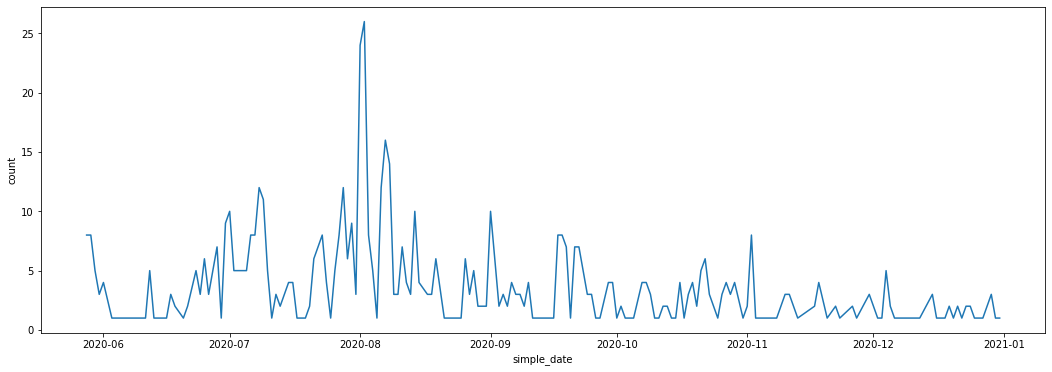

In [131]:
# Look at AAPI-focused tweets in 2020
aapi_by_date = aapi_df.groupby(['simple_date'])['id'].count().reset_index(name ='count')

fig, ax = plt.subplots(figsize = (18,6))    
sns.lineplot(ax=ax, data=aapi_by_date.loc[aapi_by_date['simple_date'] < ny_2021], x="simple_date", y="count")
